In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.naive_bayes as nb
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import sklearn.ensemble
from sklearn import tree
from sklearn import feature_selection
from sklearn.feature_selection import f_classif
import warnings
import sklearn.preprocessing
from sklearn.preprocessing import power_transform
from scipy import stats  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from matplotlib.pylab import rcParams
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import scipy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.cluster
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import math
import copy
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.cluster.hierarchy import linkage
import kneed
from kneed import KneeLocator
# %matplotlib notebook
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\Tudor\Desktop\Licenta2020\train.csv")
new_df = df.dropna()                                                                                                           # Drop rows where at least one element is missing
new_df = new_df[new_df.columns][(new_df['matchType'] == 'solo-fpp') | (new_df['matchType'] == 'solo')]                         # Keep only the rows where the match type was solo
new_df = new_df.drop(["Id", "groupId", "matchId", "killPoints", "matchType", "numGroups", "rankPoints", "teamKills", "DBNOs", "maxPlace", "revives", "vehicleDestroys", "winPoints", "assists"], axis = 1) # drop the columns that are visibly useless
new_df['winPlacePerc'] = 100 - (new_df['winPlacePerc'] * 100).astype('int32') + 1                                              # Convert from precentage to Place (Precentage 1- 1st place, 0- last place so in some kind it was backwards)
new_df.drop(new_df[(new_df['winPlacePerc'] < 1) | (new_df['winPlacePerc'] > 100)].index, inplace = True)                       # some percentages might have been wrong, so the conversion would result sometimes to bad placements. Drop those bad placements

In [3]:
def eliminate_outliers(data_frame, atr):
    aux = data_frame[[atr]].sort_values(atr)
    Q1 = aux.quantile(q = 0.25)[atr]
    Q3 = aux.quantile(q = 0.75)[atr]
    IQR = Q3 - Q1
    interval = [Q1 - 3*IQR, Q3 + 3*IQR] # less restrictive
    indexes = aux[(aux[atr] < interval[0]) | (aux[atr] > interval[1])].index
    data_frame.drop(indexes, inplace = True)
    return data_frame

''' Some players might have been hackers and so their stats could be different than the mean '''
for elem in ['damageDealt', 'longestKill', 'walkDistance', 'weaponsAcquired']:
    new_df = eliminate_outliers(new_df, elem)

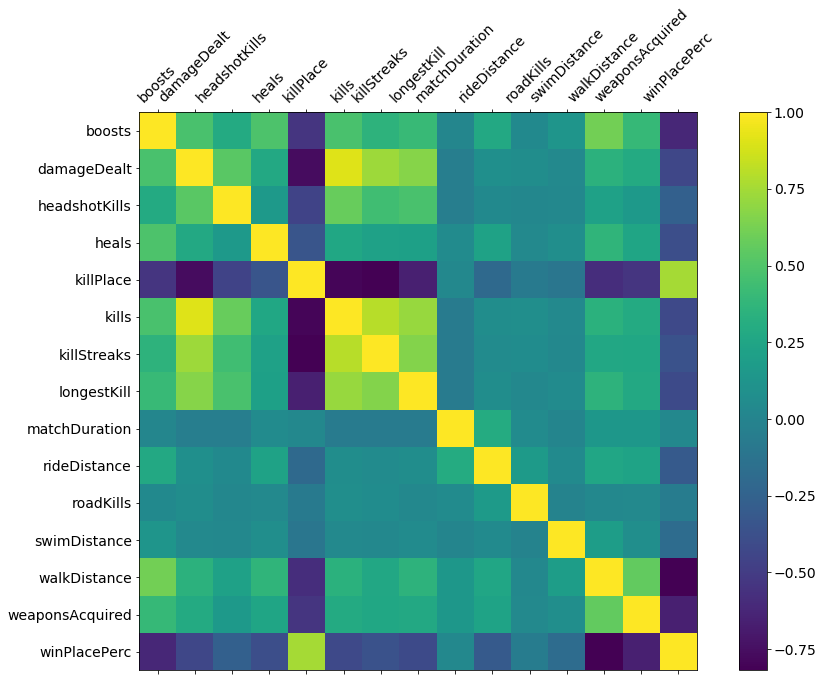

In [4]:
f = plt.figure(figsize=(15, 10))
plt.matshow(new_df.corr(), fignum=f.number)
plt.xticks(range(new_df.shape[1]), new_df.columns, fontsize=14, rotation=45)
plt.yticks(range(new_df.shape[1]), new_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

,boosts,damageDealt,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,rideDistance,roadKills,swimDistance,walkDistance,weaponsAcquired,winPlacePerc
count,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000,11366.000000
mean,0.868731,92.252311,0.153616,0.899437,50.608130,0.676403,0.418705,9.896781,1595.597924,420.422876,0.003343,4.977787,849.687165,3.431550,54.420553
std,1.545331,114.934594,0.432489,2.321196,25.628238,1.062823,0.533141,17.892164,254.123545,1332.912555,0.060699,32.802428,953.356968,2.276339,28.017909
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1044.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,1383.000000,0.000000,0.000000,0.000000,101.225000,2.000000,31.000000
50%,0.000000,58.800000,0.000000,0.000000,51.000000,0.000000,0.000000,0.000000,1451.500000,0.000000,0.000000,0.000000,440.350000,3.000000,55.500000
75%,1.000000,133.575000,0.000000,1.000000,73.000000,1.000000,1.000000,12.105000,1873.000000,0.000000,0.000000,0.000000,1387.750000,5.000000,79.000000
max,13.000000,687.400000,4.000000,39.000000,98.000000,7.000000,4.000000,82.170000,2237.000000,30660.000000,2.000000,819.400000,5132.000000,14.000000,100.000000


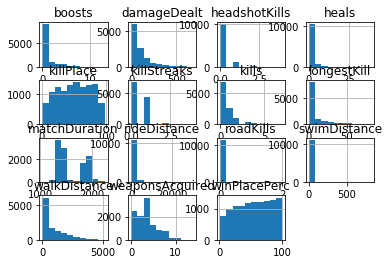

In [22]:
_ = new_df.hist()
new_df.describe()

In [23]:
'''
- Pairwise correlation - 

Many variables are correlated with each other, therefore redundant.
Analyse in pairs of 2 and if corr(Xi, Xj) >= 0.8 drop the variable argmin{Xi, Xj}(corr(X, Y)) 
'''

l = []
for i in range(0, len(new_df.columns[0: -1]) - 1):
    for j in range(i + 1, len(new_df.columns[0: -1])):
        if abs(new_df[new_df.columns[i]].corr(new_df[new_df.columns[j]])) >= 0.8:
            print('Corr(', new_df.columns[i], ',', new_df.columns[j], ')=', abs(new_df[new_df.columns[i]].corr(new_df[new_df.columns[j]])))
            l.append([new_df.columns[i], new_df.columns[j]])
# cele care trebuie eliminate
for e in l:
    if abs(new_df[e[0]].corr(new_df['winPlacePerc'])) < abs(new_df[e[1]].corr(new_df['winPlacePerc'])):
        del e[1]
    else:
        del e[0]
l = (list(map(lambda e: e[0], l)))
print(l)
l = np.unique(l)
# le elimin doar daca corelatia cu atributul de output e < 0.4
for e in l:
    if abs(new_df[e].corr(new_df['winPlacePerc'])) < 0.4:
        print('Feature', e, 'is dropped')
        new_df = new_df.drop([e], axis = 1)

Corr( damageDealt , kills )= 0.9137441046786221
Corr( killPlace , killStreaks )= 0.8187770837576835
Corr( kills , killStreaks )= 0.8011110473742187
['kills', 'killStreaks', 'killStreaks']
Feature killStreaks is dropped


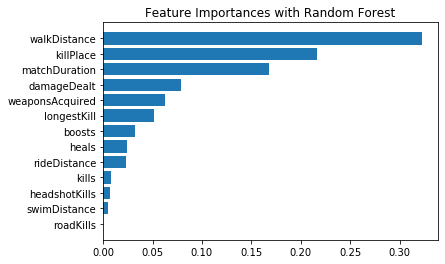

The worst feature is: roadKills


In [24]:
clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_features = None, n_jobs = -1)
clf.fit(new_df.loc[:, new_df.columns != 'winPlacePerc'], new_df[['winPlacePerc']])
features = new_df.columns[:-1]
indices = np.argsort(clf.feature_importances_)
plt.title('Feature Importances with Random Forest')
plt.barh(range(len(indices)), clf.feature_importances_[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()
print('The worst feature is:', features[indices[0]])

In [25]:
new_df['kills'] = new_df['kills'] + new_df[features[indices[0]]]
new_df = new_df.drop(['roadKills'], axis = 1)

In [26]:
normalised_df = pd.DataFrame(power_transform(new_df.loc[:, new_df.columns != 'winPlacePerc'], method = 'yeo-johnson'), columns = new_df.columns[: -1])
normalised_df['winPlacePerc'] = list(new_df['winPlacePerc'])
copie_init = copy.deepcopy(normalised_df)

Attributes belonging to clusters: [('boosts', 0), ('damageDealt', 2), ('headshotKills', 2), ('heals', 0), ('killPlace', 1), ('kills', 2), ('longestKill', 2), ('matchDuration', 0), ('rideDistance', 0), ('swimDistance', 0), ('walkDistance', 0), ('weaponsAcquired', 0)]
Number of samples in the training set now: 11366


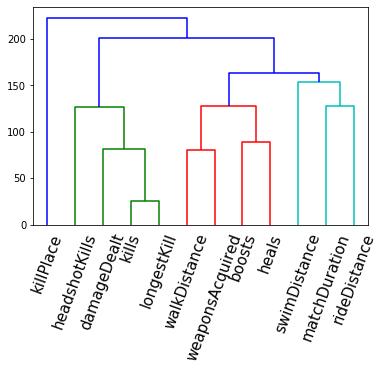

In [27]:
agglo = FeatureAgglomeration(n_clusters = 3, affinity = 'euclidean', linkage = 'ward', pooling_func = np.mean)
new_features = agglo.fit(normalised_df.loc[:, normalised_df.columns != 'winPlacePerc'])
print("Attributes belonging to clusters:", list(zip(normalised_df.columns, new_features.labels_)))
dim_reduct = agglo.transform(normalised_df.loc[:, normalised_df.columns != 'winPlacePerc'])
normalised_df_reducted = pd.DataFrame(dim_reduct, columns = ['atr1', 'atr2', 'atr3'])
normalised_df_reducted['winPlacePerc'] = normalised_df[['winPlacePerc']]
dbscan_new = copy.deepcopy(normalised_df_reducted)
kmeans_new = copy.deepcopy(dbscan_new)
print("Number of samples in the training set now:", len(normalised_df_reducted))
Z = linkage(normalised_df.loc[:, normalised_df.columns != 'winPlacePerc'].transpose(), 'ward')
dendogram = scipy.cluster.hierarchy.dendrogram(Z, p=12, labels = ['boosts', 'damageDealt', 'headshotKills', 'heals', 'killPlace', 'kills',
       'longestKill', 'matchDuration', 'rideDistance', 'swimDistance',
       'walkDistance', 'weaponsAcquired'], truncate_mode = 'lastp', leaf_rotation = 70., leaf_font_size = 15., show_contracted = True)

K using Elbow technique is:  2


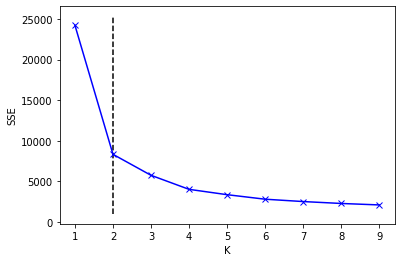

In [28]:
SSE = []
for k in range(1, 10):
    km = KMeans(n_clusters = k, init = 'k-means++', n_init = 100, n_jobs = -1, algorithm = 'full')
    km.fit(kmeans_new[['atr1', 'atr2', 'atr3']])
    SSE.append(km.inertia_)
plt.plot(range(1, 10), SSE, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
perfect_k = np.argmax(list(map(lambda e1, e2: e1 - e2, SSE, SSE[1:]))) + 2
print('K using Elbow technique is: ', perfect_k)
plt.vlines(perfect_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

The silhouette score is:  0.26985683156740947


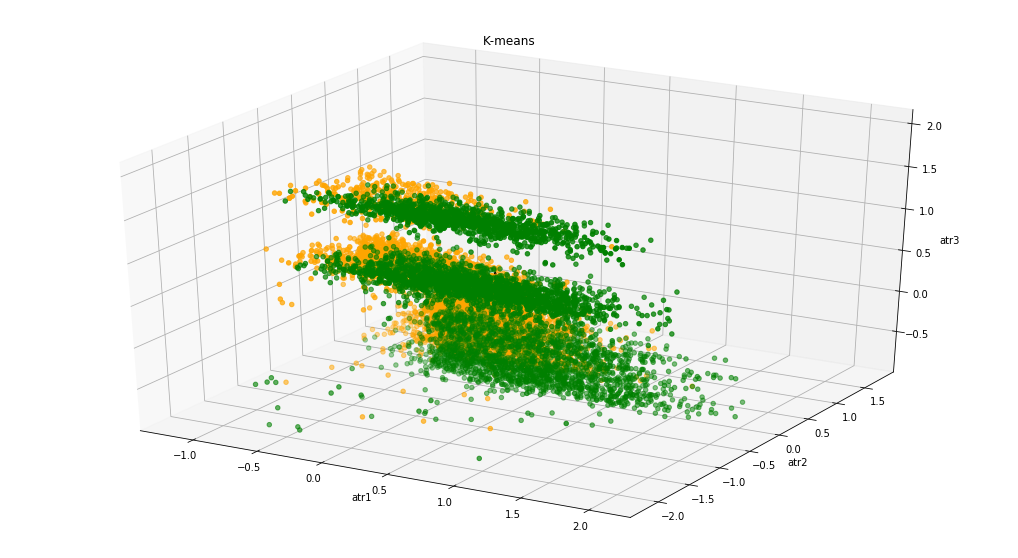

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(18, 10)
vector_of_colors = ['orange', 'green', 'cyan', 'magenta', 'red', 'yellow', 'olive']

km = KMeans(n_clusters = perfect_k, init = 'k-means++', n_init = 100, n_jobs = -1, algorithm = 'full')
kmeans_new['cluster'] = km.fit_predict(kmeans_new)
for i in kmeans_new['cluster'].unique():
     ax.scatter(kmeans_new[['atr1']][kmeans_new['cluster'] == i], kmeans_new[['atr2']][kmeans_new['cluster'] == i], kmeans_new[['atr3']][kmeans_new['cluster'] == i], color = vector_of_colors[i])
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2], marker = '*', s = 5000, color = 'black')
ax.set_xlabel('atr1'); ax.set_ylabel('atr2'); ax.set_zlabel('atr3'); ax.set_title('K-means')
print('The silhouette score is: ', metrics.silhouette_score(kmeans_new[['atr1', 'atr2', 'atr3']], kmeans_new[['cluster']], metric = 'euclidean'))

In [30]:
#math.ceil(math.log(len(dbscan_new), 2))
neigh = NearestNeighbors(n_neighbors = int((0.01 * len(dbscan_new))))
dbscan_new_as_array = np.asarray(dbscan_new.loc[:, dbscan_new.columns != 'winPlacePerc'])
neigh.fit(dbscan_new_as_array)
_ = []
for i in range(len(dbscan_new_as_array)):
    distances_from_point_to_neighs = neigh.kneighbors([list(dbscan_new_as_array[i])])[0].flatten().tolist()
    del distances_from_point_to_neighs[0]
    _.append(np.mean(distances_from_point_to_neighs))
_ = np.average(_)
print(_)

0.16335295047395018


MinPts:  46


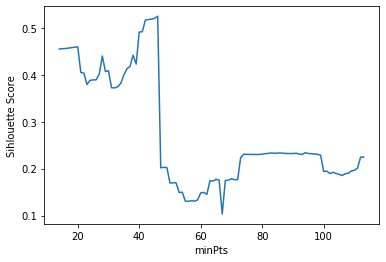

In [31]:
silhouette_scores = []
max_sh_score = -1
k = math.ceil(math.log(len(dbscan_new), 2))
while k <= int(0.01 * len(dbscan_new)):
    aux = copy.deepcopy(dbscan_new)
    dbscan = DBSCAN(eps = _, min_samples = k, metric = 'euclidean', n_jobs = -1)
    aux['cluster'] = dbscan.fit_predict(aux[['atr1', 'atr2', 'atr3']])
    aux = aux.drop(aux.index[aux['cluster'] == -1])
    silhouette_scores.append(metrics.silhouette_score(aux[['atr1', 'atr2', 'atr3']], aux[['cluster']], metric = 'euclidean'))
    if silhouette_scores[-1] > max_sh_score:
        max_sh_score = silhouette_scores[-1]
        minPts = k
    k = k + 1
plt.plot(range(math.ceil(math.log(len(dbscan_new), 2)), k, 1), silhouette_scores)
plt.xlabel('minPts')
plt.ylabel('Sihlouette Score')
print('MinPts: ', minPts)

Number of points that are noise: 216 out of 11366
[0 1 2]
The cluster with the worst average placement:  orange
The silhouette score is:  0.44936189353465983


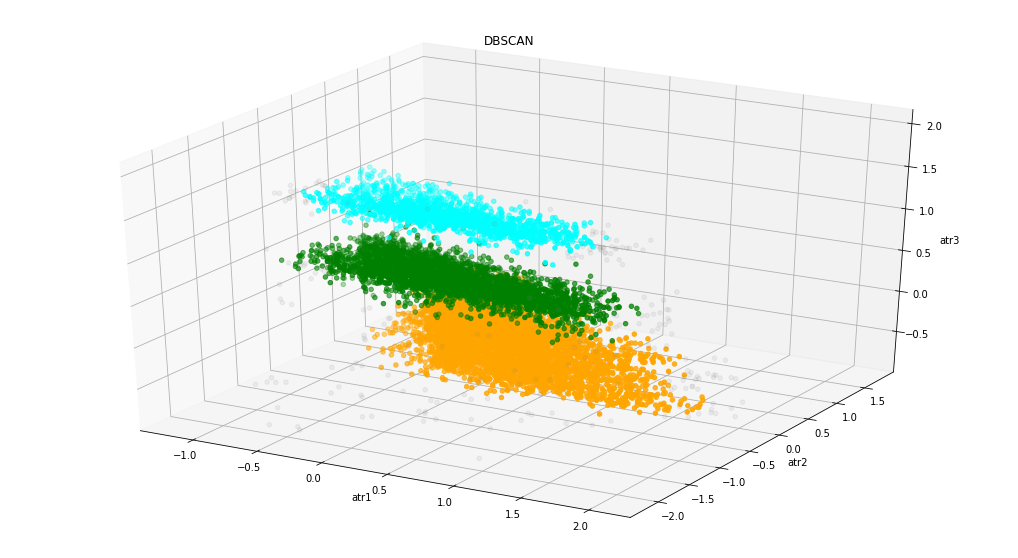

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(18, 10)
'''
aux = copy.deepcopy(dbscan_new)
dbscan = DBSCAN(eps = _ + 0.1, min_samples = minPts, metric = 'euclidean')
aux['cluster'] = dbscan.fit_predict(aux[['atr1', 'atr2', 'atr3']])
noise = aux[aux['cluster'] == -1]
ax.scatter(noise['atr1'], noise['atr2'], noise['atr3'], depthshade = True, c = 'grey', alpha = 0.1)
print("Number of points that are noise:", len(noise))
aux = aux.drop(aux.index[aux['cluster'] == -1])
print(aux['cluster'].unique())

for i in aux['cluster'].unique():
    ax.scatter(aux[['atr1']][aux['cluster'] == i], aux[['atr2']][aux['cluster'] == i], aux[['atr3']][aux['cluster'] == i], color = vector_of_colors[i])

worst_placement_cluster_mean_value = 0 
for i in aux['cluster'].unique():
    if int(aux[['winPlacePerc']][(aux['cluster'] == i)].mean()) > worst_placement_cluster_mean_value:
        worst_placement_cluster = i
        worst_placement_cluster_mean_value = int(aux[['winPlacePerc']][(aux['cluster'] == i)].mean())
print('The cluster with the worst average placement: ', vector_of_colors[worst_placement_cluster])
print('The silhouette score is: ', metrics.silhouette_score(aux[['atr1', 'atr2', 'atr3']], aux[['cluster']], metric = 'euclidean'))
'''
dbscan = DBSCAN(eps = _ + 0.1, min_samples = minPts, metric = 'euclidean')
dbscan_new['cluster'] = dbscan.fit_predict(dbscan_new[['atr1', 'atr2', 'atr3']])
noise = dbscan_new[dbscan_new['cluster'] == -1]
ax.scatter(noise['atr1'], noise['atr2'], noise['atr3'], depthshade = True, c = 'grey', alpha = 0.1)
print("Number of points that are noise:", len(noise), 'out of', len(dbscan_new))
dbscan_new = dbscan_new.drop(dbscan_new.index[dbscan_new['cluster'] == -1])
print(dbscan_new['cluster'].unique())

for i in dbscan_new['cluster'].unique():
    ax.scatter(dbscan_new[['atr1']][dbscan_new['cluster'] == i], dbscan_new[['atr2']][dbscan_new['cluster'] == i], dbscan_new[['atr3']][dbscan_new['cluster'] == i], color = vector_of_colors[i])

worst_placement_cluster_mean_value = 0 
for i in dbscan_new['cluster'].unique():
    if int(dbscan_new[['winPlacePerc']][(dbscan_new['cluster'] == i)].mean()) > worst_placement_cluster_mean_value:
        worst_placement_cluster = i
        worst_placement_cluster_mean_value = int(dbscan_new[['winPlacePerc']][(dbscan_new['cluster'] == i)].mean())
ax.set_xlabel('atr1'); ax.set_ylabel('atr2'); ax.set_zlabel('atr3'); ax.set_title('DBSCAN')
print('The cluster with the worst average placement: ', vector_of_colors[worst_placement_cluster])
print('The silhouette score is: ', metrics.silhouette_score(dbscan_new[['atr1', 'atr2', 'atr3']], dbscan_new[['cluster']], metric = 'euclidean'))

Out of  6720  samples that are in the worst cluster, only 147  are in top 10.


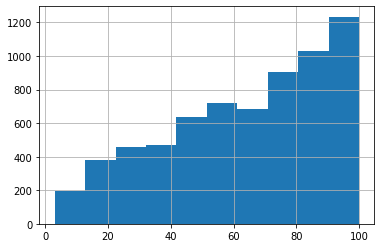

In [33]:
the_worst_cluster = dbscan_new[dbscan_new['cluster'] == worst_placement_cluster]
the_worst_cluster['winPlacePerc'].hist()
print('Out of ', len(the_worst_cluster), ' samples that are in the worst cluster, only',
     len(the_worst_cluster[the_worst_cluster['winPlacePerc'] <= 10]), ' are in top 10.')

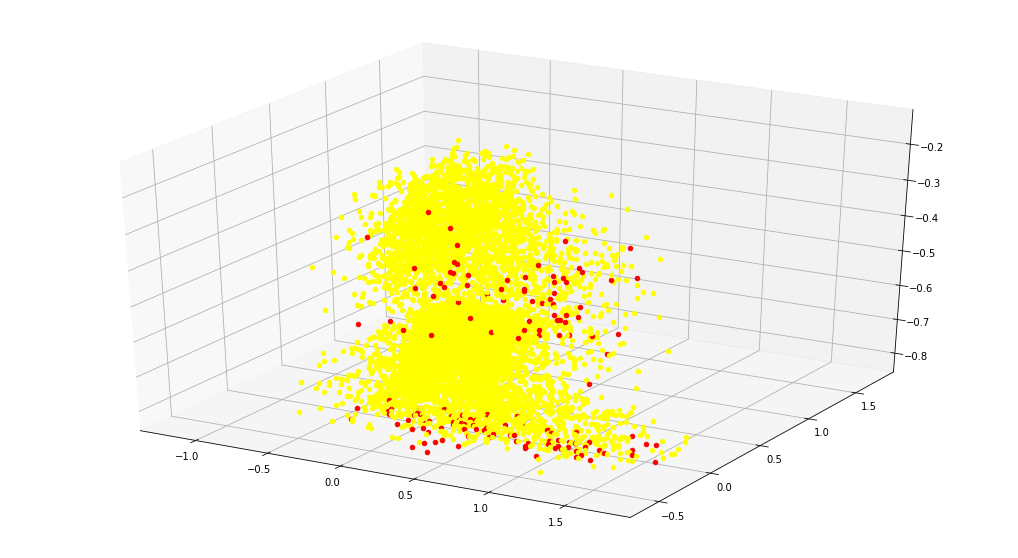

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(18, 10)
win_place_perc = the_worst_cluster.apply(lambda e: 1 if e['winPlacePerc'] <= 10 else 0, axis = 1)
the_worst_cluster['winPlacePerc'] = list(win_place_perc)
for e in the_worst_cluster.index:
    if the_worst_cluster.loc[e][3] == 1:
        ax.scatter(the_worst_cluster.loc[e][0], the_worst_cluster.loc[e][1], the_worst_cluster.loc[e][2], depthshade = True, c = 'red')
    else:
        ax.scatter(the_worst_cluster.loc[e][0], the_worst_cluster.loc[e][1], the_worst_cluster.loc[e][2], depthshade = True, c = 'yellow')

In [35]:
clf = tree.DecisionTreeClassifier()
clf.fit(the_worst_cluster[['atr1', 'atr2', 'atr3']], the_worst_cluster['winPlacePerc'])
depth_full_DT = clf.get_depth()

min_error_DT = len(the_worst_cluster)
for k in range(1, depth_full_DT + 1):
    clf = tree.DecisionTreeClassifier(max_depth = k)
    kf = KFold(n_splits = len(the_worst_cluster))
    error = 0
    for train_kf, test_kf in kf.split(the_worst_cluster):
        clf.fit( (the_worst_cluster.iloc[train_kf]).loc[:, the_worst_cluster.columns != 'winPlacePerc'], 
                    (the_worst_cluster.iloc[train_kf])['winPlacePerc']
                 )
        error += int(clf.predict((the_worst_cluster.iloc[test_kf]).loc[:, the_worst_cluster.columns != 'winPlacePerc']) != (the_worst_cluster.iloc[test_kf])['winPlacePerc'])                        
    if error < min_error_DT:
        min_error_DT = error
        for_what_depth = k
print(min_error_DT, for_what_depth)

145 4


In [36]:
clf = tree.DecisionTreeClassifier(max_depth = 4)
clf.fit(the_worst_cluster[['atr1', 'atr2', 'atr3']], the_worst_cluster['winPlacePerc'])
predicted = clf.predict(the_worst_cluster[['atr1', 'atr2', 'atr3']])
real = list(the_worst_cluster['winPlacePerc'])
confusion_matrix(real, predicted)

array([[6572,    1],
       [ 132,   15]], dtype=int64)

In [37]:
grid_search = RandomizedSearchCV(estimator = AdaBoostClassifier(algorithm = 'SAMME'), 
                                 param_distributions = {'n_estimators': scipy.stats.randint(50, 1000), 
                                                        'learning_rate':  np.random.uniform(1, 3, 1000)},
                                 n_iter = 1000,
                                 scoring = 'balanced_accuracy', 
                                 n_jobs = -1,
                                 cv = None
                                )
grid_search.fit(the_worst_cluster[['atr1', 'atr2', 'atr3']],  the_worst_cluster['winPlacePerc'])
r =pd.DataFrame(grid_search.cv_results_)
r[r['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
268,0.462362,0.017085,0.024335,0.000489,1.98367,86,"{'learning_rate': 1.9836699266219384, 'n_estim...",0.749377,0.812259,0.770801,0.726712,0.766134,0.765057,0.028208,1


In [38]:
#432, 2.00595
# clf = AdaBoostClassifier(n_estimators = int(r['param_n_estimators'][r['rank_test_score'] == 1]), 
#                          learning_rate =float(r['param_learning_rate'][r['rank_test_score'] == 1]), 
#                          algorithm = 'SAMME')
clf = AdaBoostClassifier(n_estimators = 432, 
                         learning_rate = 2.00595, 
                         algorithm = 'SAMME')
clf.fit(the_worst_cluster[['atr1', 'atr2', 'atr3']], the_worst_cluster['winPlacePerc'])
predicted = clf.predict(the_worst_cluster[['atr1', 'atr2', 'atr3']])
real = list(the_worst_cluster['winPlacePerc'])
confusion_matrix(real, predicted)

array([[6338,  235],
       [   0,  147]], dtype=int64)

In [39]:
df = pd.read_csv(r"C:\Users\Tudor\Desktop\Licenta2020\test.csv")
new_df = df.dropna()                                                                                                           # Drop rows where at least one element is missing
new_df = new_df[new_df.columns][(new_df['matchType'] == 'solo-fpp') | (new_df['matchType'] == 'solo')]                         # Keep only the rows where the match type was solo
new_df = new_df.drop(["Id", "groupId", "matchId", "killPoints", "matchType", "numGroups", "rankPoints", "teamKills", "DBNOs", "maxPlace", "revives", "vehicleDestroys", "winPoints", "assists"], axis = 1) # drop the columns that are visibly useless
new_df['winPlacePerc'] = 100 - (new_df['winPlacePerc'] * 100).astype('int32') + 1                                              # Convert from precentage to Place (Precentage 1- 1st place, 0- last place so in some kind it was backwards)
new_df.drop(new_df[(new_df['winPlacePerc'] < 1) | (new_df['winPlacePerc'] > 100)].index, inplace = True)                       # some percentages might have been wrong, so the conversion would result sometimes to bad placements. Drop those bad placements
new_df = new_df.drop('killStreaks', axis = 1)
new_df['kills'] = new_df['kills'] + new_df[features[indices[0]]]
new_df = new_df.drop(['roadKills'], axis = 1)
normalised_df = pd.DataFrame(power_transform(new_df.loc[:, new_df.columns != 'winPlacePerc'], method = 'yeo-johnson'), columns = new_df.columns[: -1])
normalised_df['winPlacePerc'] = list(new_df['winPlacePerc'])
agglo = FeatureAgglomeration(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
new_features = agglo.fit(normalised_df.loc[:, normalised_df.columns != 'winPlacePerc'])
dim_reduct = agglo.transform(normalised_df.loc[:, normalised_df.columns != 'winPlacePerc'])
normalised_df_reducted = pd.DataFrame(dim_reduct, columns = ['atr1', 'atr2', 'atr3'])
normalised_df_reducted['winPlacePerc'] = normalised_df[['winPlacePerc']]
win_place_perc = normalised_df_reducted.apply(lambda e: 1 if e['winPlacePerc'] <= 10 else 0, axis = 1)
normalised_df_reducted['winPlacePerc'] = list(win_place_perc)

In [40]:
neigh = NearestNeighbors(n_neighbors = minPts)
normalised_df_reducted_as_array = np.asarray(normalised_df_reducted.loc[:, normalised_df_reducted.columns != 'winPlacePerc'])
dbscan_new_as_array = np.asarray(dbscan_new.loc[:, (dbscan_new.columns != 'winPlacePerc') & (dbscan_new.columns != 'cluster')])
neigh.fit(dbscan_new_as_array)

points_in_worst_cluster = []
for i in range(len(normalised_df_reducted_as_array)):
    nearestNeighbs = neigh.kneighbors([list(normalised_df_reducted_as_array[i])])[1].flatten().tolist()
    del nearestNeighbs[0]
    nr = 0
    for e in nearestNeighbs:
        if dbscan_new.loc[dbscan_new.index[e]][4] == worst_placement_cluster:
            nr += 1
    if nr >= int(0.95 * minPts):
        points_in_worst_cluster.append(i)
        

---------------------------- Adaboost -----------------------------------------------------
Number of mislabeled points out of a total 6728 points : 389
The accuracy score is : 0.942182
[[6293  293]
 [  96   46]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6586
           1       0.14      0.32      0.19       142

    accuracy                           0.94      6728
   macro avg       0.56      0.64      0.58      6728
weighted avg       0.97      0.94      0.95      6728

Balanced accuacy score:  0.6397276767192893


Text(0.5, 1.0, '2-class AdaBoost Precision Recall Curve')

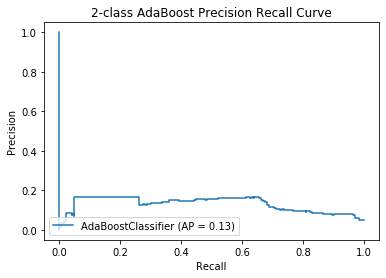

In [41]:
dataframe_to_test = normalised_df_reducted[normalised_df_reducted.index.isin(points_in_worst_cluster)]
real_label = dataframe_to_test['winPlacePerc']
predictor = clf.predict(dataframe_to_test[['atr1', 'atr2', 'atr3']])

print('---------------------------- Adaboost -----------------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (dataframe_to_test.shape[0], (real_label != predictor).sum()))
print("The accuracy score is : %f" % (accuracy_score(real_label, predictor)))
cm = confusion_matrix(real_label, predictor)
print(cm)
print(classification_report(real_label, predictor))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(real_label, predictor))
disp = sklearn.metrics.plot_precision_recall_curve(clf, dataframe_to_test[['atr1', 'atr2', 'atr3']], dataframe_to_test['winPlacePerc'])
disp.ax_.set_title('2-class AdaBoost Precision Recall Curve')

In [709]:
# ----------------------------------------------------------------------------------------------------------------------------
                         # Dataframeu asta il testezi cu supervised

In [42]:
normalised_df = normalised_df.drop(dataframe_to_test.index)
normalised_df

,boosts,damageDealt,headshotKills,heals,killPlace,kills,longestKill,matchDuration,rideDistance,swimDistance,walkDistance,weaponsAcquired,winPlacePerc
0,0.783813,0.644938,-0.480330,1.116972,-0.738493,0.693562,1.080869,-0.669079,-0.495053,-0.256324,0.290142,-0.112865,23
2,1.420984,0.253691,-0.480330,1.757152,-0.493700,0.693562,1.082276,0.992585,-0.495053,-0.256324,0.496641,1.018492,51
3,-0.798306,1.261358,2.074409,-0.691176,-1.740947,1.705626,1.240621,-1.215953,-0.495053,-0.256324,-0.476940,0.684009,48
4,-0.798306,0.453438,-0.480330,-0.691176,-0.187623,0.693562,0.528779,-0.741821,-0.495053,-0.256324,-0.871748,-0.112865,66
5,1.598244,1.536018,2.074409,1.483033,-1.677291,1.607806,0.956950,-0.557845,-0.495053,-0.256324,1.374582,0.311408,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12663,-0.798306,0.810551,-0.480330,-0.691176,-0.493700,0.693562,0.569313,1.099484,-0.495053,-0.256324,1.063820,-0.112865,38
12664,-0.798306,0.453438,-0.480330,-0.691176,-0.224811,0.693562,0.573055,1.219428,-0.495053,-0.256324,-0.197913,-0.112865,61
12666,1.420984,0.871068,-0.480330,-0.691176,-0.696613,0.693562,1.418257,-1.319197,-0.495053,-0.256324,0.915617,0.684009,15
12667,0.783813,0.876680,-0.480330,-0.691176,-0.573644,0.693562,0.257484,-0.429326,-0.495053,-0.256324,0.564356,1.604792,23


In [ ]:
# --------------------------------------------------------------------------------------------------------------------------

In [43]:
not_in_worst_cluster = copie_init.drop(dbscan_new[dbscan_new['cluster'] == worst_placement_cluster].index)
not_in_worst_cluster

,boosts,damageDealt,headshotKills,heals,killPlace,kills,longestKill,matchDuration,rideDistance,swimDistance,walkDistance,weaponsAcquired,winPlacePerc
1,0.998804,0.980039,-0.384813,1.304124,-0.808024,0.992469,0.908307,-1.191047,-0.462171,-0.257266,0.445053,0.408816,48
2,-0.741966,0.903794,-0.384813,-0.639005,-0.561770,1.419677,0.905836,1.032307,2.168635,-0.257266,0.086846,0.408816,57
5,-0.741966,0.630916,2.598210,-0.639005,-0.643006,0.992469,1.270655,-0.172183,-0.462171,-0.257266,-0.025823,0.785538,56
9,1.389137,1.421278,-0.384813,1.724883,-1.329297,1.419677,1.530290,0.009440,-0.462171,-0.257266,1.047852,1.429234,33
10,-0.741966,0.960919,2.598210,-0.639005,-1.194493,1.419677,1.517132,-1.005884,-0.462171,-0.257266,0.478535,0.785538,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11349,1.726039,0.657441,2.598210,1.724883,-1.468049,0.992469,1.290610,1.164930,2.178283,-0.257266,1.049376,-0.021764,6
11351,0.998804,0.630916,-0.384813,1.304124,-0.643006,0.992469,1.438576,0.922721,2.159993,-0.257266,0.306934,-0.021764,57
11354,-0.741966,0.941649,-0.384813,-0.639005,-0.766432,0.992469,-0.063859,-0.596305,-0.462171,-0.257266,-0.004175,1.122666,44
11355,1.389137,1.244349,2.598210,-0.639005,-1.660914,1.419677,1.495520,-1.427904,2.095102,3.907278,1.187438,0.785538,9


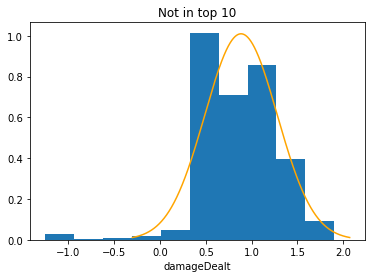

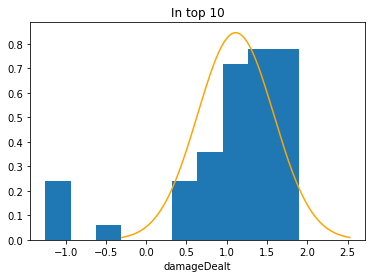

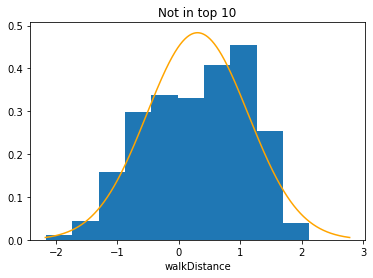

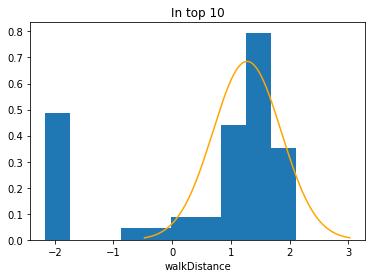

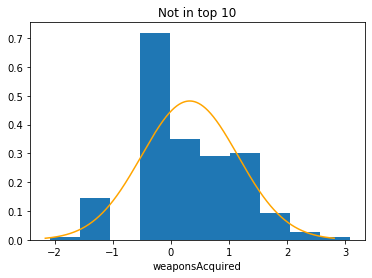

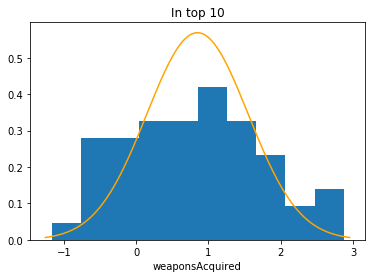

In [44]:
for e in ['damageDealt', 'walkDistance', 'weaponsAcquired']:
    miu = not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] > 10)].mean()
    std = not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] > 10)].std()
    x = np.linspace(miu - 3 * std, miu + 3 * std, len(not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] > 10)]))
    plt.plot(x, stats.norm.pdf(x, miu, std), color = 'orange')
    plt.hist(not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] > 10)], normed = True)
    plt.xlabel(e)
    plt.title('Not in top 10')
    plt.show()
    miu = not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] <= 10)].mean()
    std = not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] <= 10)].std()
    x = np.linspace(miu - 3 * std, miu + 3 * std, len(not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] <= 10)]))
    plt.plot(x, stats.norm.pdf(x, miu, std), color = 'orange')
    plt.hist(not_in_worst_cluster[e][(not_in_worst_cluster['winPlacePerc'] == 1)], normed = True)
    plt.title('In top 10')
    plt.xlabel(e)
    plt.show()

In [45]:
em_gmm_dmg = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = [[-0.95], [1.5]], random_state=3, max_iter = 100)
em_gmm_dmg.fit_predict(not_in_worst_cluster[['damageDealt']][not_in_worst_cluster['winPlacePerc'] <= 10])
em_gmm_dmg.means_, em_gmm_dmg.covariances_ 

em_gmm_walk = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = [[-1.858], [1.5]], random_state=3, max_iter = 100)
em_gmm_walk.fit_predict(not_in_worst_cluster[['walkDistance']][not_in_worst_cluster['winPlacePerc'] <= 10])
em_gmm_walk.means_, em_gmm_walk.covariances_ 

em_gmm_weapons = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = [[-1.2], [-0.5]], random_state=3, max_iter = 100)
em_gmm_weapons.fit_predict(not_in_worst_cluster[['weaponsAcquired']][not_in_worst_cluster['winPlacePerc'] > 10])
em_gmm_weapons.means_, em_gmm_weapons.covariances_ 

em_gmm_dmg_not = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = [[-0.9], [0.25]], random_state=3, max_iter = 100)
em_gmm_dmg_not.fit_predict(not_in_worst_cluster[['damageDealt']][not_in_worst_cluster['winPlacePerc'] > 10])
em_gmm_dmg_not.means_, em_gmm_dmg_not.covariances_ 

(array([[-0.7822939 ],
        [ 0.91228132]]),
 array([0.32445531, 0.105421  ]))

In [46]:
# y=1 if in top 10, 0 otherwise
def calc_prob_sample(x_i, i, y):
    if i == 'damageDealt' and y == True:
        miu = float(em_gmm_dmg.means_[em_gmm_dmg.predict(x_i)][0][0])
        std = math.sqrt(float(em_gmm_dmg.covariances_[em_gmm_dmg.predict(x_i)][0]))
        return scipy.stats.norm(miu, std).pdf(float(x_i[i]))
    if i == 'damageDealt' and y == False:
        miu = float(em_gmm_dmg_not.means_[em_gmm_dmg_not.predict(x_i)][0][0])
        std = math.sqrt(float(em_gmm_dmg_not.covariances_[em_gmm_dmg_not.predict(x_i)][0]))
        return scipy.stats.norm(miu, std).pdf(float(x_i[i]))
    if i == "walkDistance" and y == True:
        miu = float(em_gmm_walk.means_[em_gmm_walk.predict(x_i)][0][0])
        std = math.sqrt(float(em_gmm_walk.covariances_[em_gmm_walk.predict(x_i)][0]))
        return scipy.stats.norm(miu, std).pdf(float(x_i[i]))
    if i == "weaponsAcquired" and y == False:
        miu = float(em_gmm_weapons.means_[em_gmm_weapons.predict(x_i)][0][0])
        std = math.sqrt(float(em_gmm_weapons.covariances_[em_gmm_weapons.predict(x_i)][0]))
        return scipy.stats.norm(miu, std).pdf(float(x_i[i]))
    
    if y == True:
        miu = not_in_worst_cluster[i][not_in_worst_cluster['winPlacePerc'] <= 10].mean()
        std = not_in_worst_cluster[i][not_in_worst_cluster['winPlacePerc'] <= 10].std()
        return scipy.stats.norm(miu, std).pdf(float(x_i[i]))
    else:
        miu = not_in_worst_cluster[i][not_in_worst_cluster['winPlacePerc'] > 10].mean()
        std = not_in_worst_cluster[i][not_in_worst_cluster['winPlacePerc'] > 10].std()
        return scipy.stats.norm(miu, std).pdf(float(x_i[i]))

prob_top = len(not_in_worst_cluster[not_in_worst_cluster[['winPlacePerc']] <= 10])/(len(not_in_worst_cluster[not_in_worst_cluster[['winPlacePerc']] <= 10]) + len(not_in_worst_cluster[not_in_worst_cluster[['winPlacePerc']] > 10]))
prob_not_top = len(not_in_worst_cluster[not_in_worst_cluster[['winPlacePerc']] > 10])/(len(not_in_worst_cluster[not_in_worst_cluster[['winPlacePerc']] <= 10]) + len(not_in_worst_cluster[not_in_worst_cluster[['winPlacePerc']] > 10]))
def gaussian_nb(frame_):

    yes = calc_prob_sample(frame_[['damageDealt']], 'damageDealt', True)*calc_prob_sample(frame_[['walkDistance']], 'walkDistance', True)*calc_prob_sample(frame_[['weaponsAcquired']], 'weaponsAcquired', True)*prob_top

    no = calc_prob_sample(frame_[['damageDealt']], 'damageDealt', False)*calc_prob_sample(frame_[['walkDistance']], 'walkDistance', False)*calc_prob_sample(frame_[['weaponsAcquired']], 'weaponsAcquired', False)*prob_not_top
    
    if yes > no:
        return True
    else:
        return False

In [47]:
x_test_gmm_nb = normalised_df[['damageDealt', 'walkDistance', 'weaponsAcquired']]
y_pred_gmm_nb = []
for e in x_test_gmm_nb.index:
    y_pred_gmm_nb.append(gaussian_nb(x_test_gmm_nb.loc[[e]]))
y_test_gmm_nb = normalised_df.apply(lambda e: 1 if e['winPlacePerc'] <= 10 else 0, axis = 1)

print('---------------------------- GMM Gaussian Naive Bayes -----------------------------------------------------')
print()
print("Number of mislabeled points out of a total %d points : %d" % (x_test_gmm_nb.shape[0], (y_test_gmm_nb != y_pred_gmm_nb).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_gmm_nb, y_pred_gmm_nb)))
cm = confusion_matrix(y_test_gmm_nb, y_pred_gmm_nb)
print(cm)
print(classification_report(y_test_gmm_nb, y_pred_gmm_nb))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_gmm_nb, y_pred_gmm_nb))

---------------------------- GMM Gaussian Naive Bayes -----------------------------------------------------

Number of mislabeled points out of a total 5946 points : 1517
The accuracy score is : 0.744871
[[3515 1375]
 [ 142  914]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      4890
           1       0.40      0.87      0.55      1056

    accuracy                           0.74      5946
   macro avg       0.68      0.79      0.68      5946
weighted avg       0.86      0.74      0.77      5946

Balanced accuacy score:  0.7921721044803867


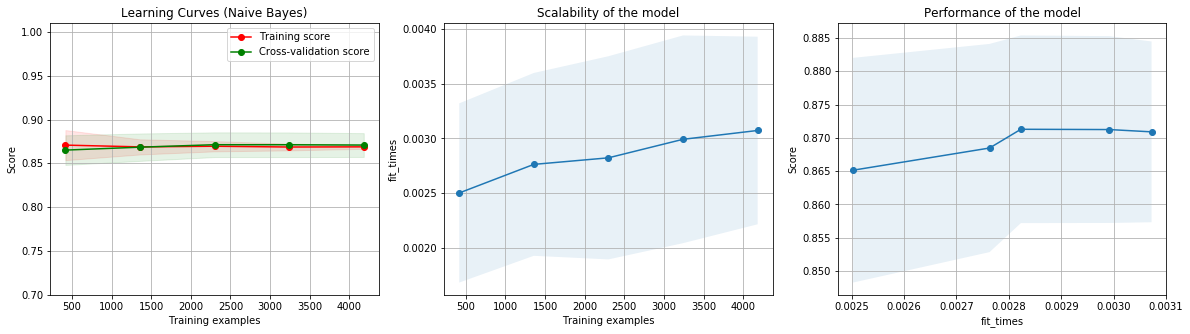

---------------------------- Gaussian Naive Bayes -----------------------------------------------------

Number of mislabeled points out of a total 5946 points : 838
The accuracy score is : 0.859065
[[4714  176]
 [ 662  394]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4890
           1       0.69      0.37      0.48      1056

    accuracy                           0.86      5946
   macro avg       0.78      0.67      0.70      5946
weighted avg       0.84      0.86      0.84      5946

Balanced accuacy score:  0.6685571202825804


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


x_train_nb = not_in_worst_cluster[['damageDealt', 'walkDistance', 'weaponsAcquired']]
y_train_nb = not_in_worst_cluster.apply(lambda e: 1 if e['winPlacePerc'] <= 10 else 0, axis = 1)

x_test_nb = normalised_df[['damageDealt', 'walkDistance', 'weaponsAcquired']]
y_test_nb = normalised_df[['winPlacePerc']].apply(lambda e: 1 if e['winPlacePerc'] <= 10 else 0, axis = 1)

gnb = GaussianNB()
gnb.fit(x_train_nb, y_train_nb)
y_pred_nb = gnb.predict(x_test_nb)


title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)
plot_learning_curve(gnb, title, x_train_nb, y_train_nb, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()

print('---------------------------- Gaussian Naive Bayes -----------------------------------------------------')
print()
print("Number of mislabeled points out of a total %d points : %d" % (x_test_nb.shape[0], (y_test_nb != y_pred_nb).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_nb, y_pred_nb)))
cm = confusion_matrix(y_test_nb, y_pred_nb)
print(cm)
print(classification_report(y_test_nb, y_pred_nb))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_nb, y_pred_nb))

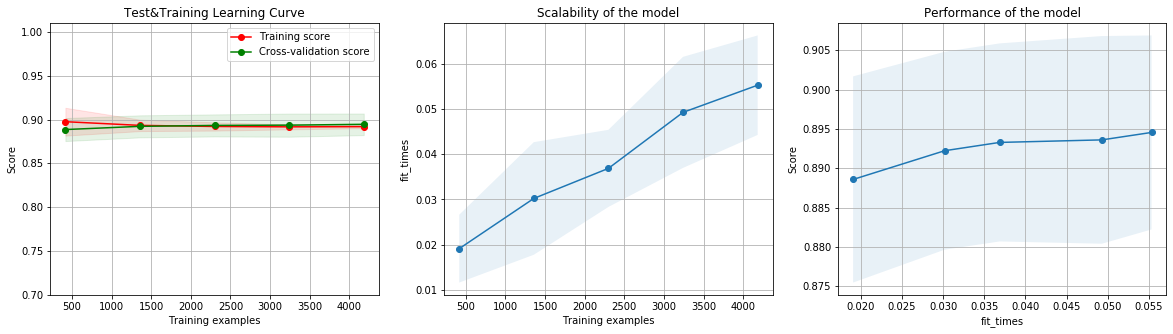

---------------------------- Logistic Regression -----------------------------------------------------

Number of mislabeled points out of a total 5946 points : 816
The accuracy score is : 0.862765
[[4811   79]
 [ 737  319]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      4890
           1       0.80      0.30      0.44      1056

    accuracy                           0.86      5946
   macro avg       0.83      0.64      0.68      5946
weighted avg       0.86      0.86      0.84      5946

Balanced accuacy score:  0.6429639570552147


In [49]:
logreg = LogisticRegression()
x_train_general = not_in_worst_cluster[not_in_worst_cluster.columns[:-1]]
y_train_general = not_in_worst_cluster[['winPlacePerc']].apply(lambda e: 1 if e['winPlacePerc'] <= 10 else 0, axis = 1)
logreg.fit(x_train_general, y_train_general)

x_test_general = normalised_df[normalised_df.columns[:-1]]
y_test_general = normalised_df[['winPlacePerc']].apply(lambda e: 1 if e['winPlacePerc'] <= 10 else 0, axis = 1)
y_pred_lg = logreg.predict(x_test_general)

title = "Test&Training Learning Curve"
cv = ShuffleSplit(n_splits=100, test_size=0.10, random_state=0)
plot_learning_curve(logreg, title, x_train_general, y_train_general, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()

print('---------------------------- Logistic Regression -----------------------------------------------------')
print()
print("Number of mislabeled points out of a total %d points : %d" % (x_test_general.shape[0], (y_test_general != y_pred_lg).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_general, y_pred_lg)))
cm = confusion_matrix(y_test_general, y_pred_lg)
print(cm)
print(classification_report(y_test_general, y_pred_lg))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_general, y_pred_lg))

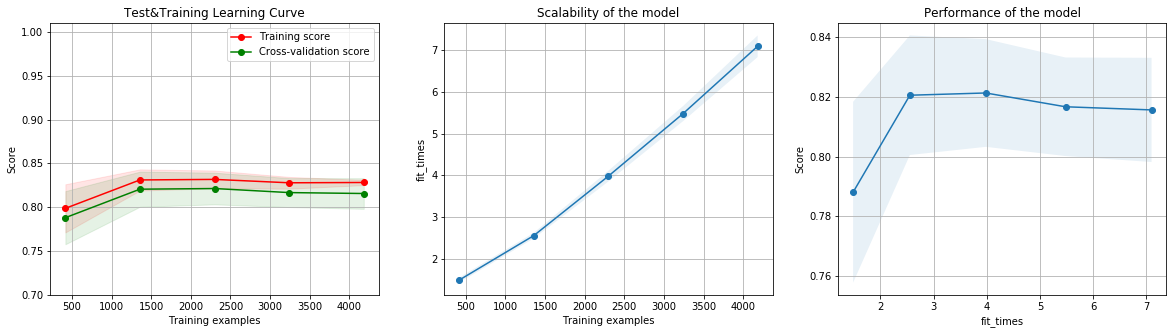

---------------------------- Random Forest -----------------------------------------------------
Number of mislabeled points out of a total 5946 points : 853
The accuracy score is : 0.856542
[[4313  577]
 [ 276  780]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      4890
           1       0.57      0.74      0.65      1056

    accuracy                           0.86      5946
   macro avg       0.76      0.81      0.78      5946
weighted avg       0.88      0.86      0.86      5946

Balanced accuacy score:  0.8103202268079569


In [52]:
grid_search = RandomizedSearchCV(estimator = RandomForestClassifier(criterion = 'entropy'), 
                                 param_distributions = {'n_estimators' : scipy.stats.randint(1, 1001),
                                                        'max_depth' : scipy.stats.randint(1, depth_full_tree), 
                                                        'min_samples_split' : scipy.stats.randint(2, 50),
                                                        'min_samples_leaf' : scipy.stats.randint(1, 50),
                                                        'max_features' : ["sqrt", "log2", None],
                                                        'class_weight' : ['balanced', 'balanced_subsample']
                                                        },
                                 n_iter = 100,
                                 scoring = 'balanced_accuracy', 
                                 n_jobs = -1,
                                 cv = None
                                )
grid_search.fit(x_train_general,  y_train_general)
r = pd.DataFrame(grid_search.cv_results_)
rf_params = r[r['rank_test_score'] == 1].head(1)
#----------------------------------------------------------------------------------------------------------------------------#


RF = RandomForestClassifier(n_estimators = rf_params[['param_n_estimators']].iloc[0]['param_n_estimators'],
                            max_depth = rf_params[['param_max_depth']].iloc[0]['param_max_depth'],
                            min_samples_split = rf_params[['param_min_samples_split']].iloc[0]['param_min_samples_split'],
                            min_samples_leaf = rf_params[['param_min_samples_leaf']].iloc[0]['param_min_samples_leaf'],
                            max_features = rf_params[['param_max_features']].iloc[0]['param_max_features'],
                            class_weight = rf_params[['param_class_weight']].iloc[0]['param_class_weight']
                            )
RF.fit(x_train_general, y_train_general)

y_pred_rf = RF.predict(x_test_general)

title = "Test&Training Learning Curve"
cv = ShuffleSplit(n_splits=100, test_size=0.10, random_state=0)
plot_learning_curve(RF, title, x_train_general, y_train_general, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()

print('---------------------------- Random Forest -----------------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (x_test_general.shape[0], (y_test_general != y_pred_rf).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_general, y_pred_rf)))
cm = confusion_matrix(y_test_general, y_pred_rf)
print(cm)
print(classification_report(y_test_general, y_pred_rf))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_general, y_pred_rf))

23
---------------------------- Decision Trees -----------------------------------------------------
Number of mislabeled points out of a total 5946 points : 1148
The accuracy score is : 0.806929
[[3970  920]
 [ 228  828]]
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      4890
           1       0.47      0.78      0.59      1056

    accuracy                           0.81      5946
   macro avg       0.71      0.80      0.73      5946
weighted avg       0.86      0.81      0.82      5946

Balanced accuacy score:  0.7979759248931029


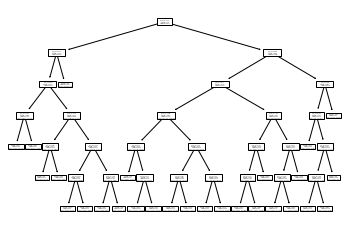

In [51]:
depth_full_tree = tree.DecisionTreeClassifier(criterion = 'entropy').fit(x_train_general, y_train_general).get_depth()
print(depth_full_tree)
grid_search = RandomizedSearchCV(estimator = tree.DecisionTreeClassifier(criterion = 'entropy', class_weight = 'balanced'), 
                                 param_distributions = {'max_depth' : scipy.stats.randint(1, depth_full_tree), 
                                                        'min_samples_split' : scipy.stats.randint(2, 50),
                                                        'min_samples_leaf' : scipy.stats.randint(1, 50)},
                                 n_iter = 1000,
                                 scoring = 'balanced_accuracy', 
                                 n_jobs = -1,
                                 cv = None
                                )
grid_search.fit(x_train_general,  y_train_general)
r = pd.DataFrame(grid_search.cv_results_)
dt_params = r[r['rank_test_score'] == 1].head(1)

DT = tree.DecisionTreeClassifier(criterion = 'entropy', 
                                  max_depth = dt_params[['param_max_depth']].iloc[0]['param_max_depth'],
                                  min_samples_leaf = dt_params[['param_min_samples_leaf']].iloc[0]['param_min_samples_leaf'],
                                  min_samples_split = dt_params[['param_min_samples_split']].iloc[0]['param_min_samples_split'],
                                  class_weight = 'balanced')
DT.fit(x_train_general, y_train_general)
tree_img = tree.plot_tree(DT)
y_pred_dt = DT.predict(x_test_general)

print('---------------------------- Decision Trees -----------------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (x_test_general.shape[0], (y_test_general != y_pred_dt).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_general, y_pred_dt)))
cm = confusion_matrix(y_test_general, y_pred_dt)
print(cm)
print(classification_report(y_test_general, y_pred_dt))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_general, y_pred_dt))

In [54]:
leaves = []
feature_to_split_on_at_each_node = list(DT.tree_.feature)
for i in range(len(feature_to_split_on_at_each_node)):
    if feature_to_split_on_at_each_node[i] == tree._tree.TREE_UNDEFINED:
        leaves.append(i)
# and abs(DT.tree_.value[e][0][0] - DT.tree_.value[e][0][1]) > 50         
leaves = list(filter(lambda e: DT.tree_.value[e][0][0] != 0 and DT.tree_.value[e][0][1] != 0 and min(DT.tree_.value[e][0][0], DT.tree_.value[e][0][1]) / (DT.tree_.value[e][0][0] + DT.tree_.value[e][0][1]) > 0.10 , leaves))
print(leaves)
for e in leaves:
    print(DT.tree_.value[e])
    

tree_samples_x = np.array(x_train_general).astype(np.float32)
tree_samples_y = np.array(y_train_general)

x_train_for_SVM = [[] for i in range(DT.tree_.node_count)]
y_train_for_SVM = [[] for i in range(DT.tree_.node_count)]
loca = -1
for e in DT.tree_.apply(tree_samples_x):
    loca += 1
    if e in leaves:
        x_train_for_SVM[e].append(tree_samples_x[loca])
        y_train_for_SVM[e].append(tree_samples_y[loca])

# Prepare the vectors so I can use GridSearch
#-----------------------------------------------------------------------------#        
auxx1 = []
for i in range(len(x_train_for_SVM)):
    if len(x_train_for_SVM[i]) != 0:
        for e in x_train_for_SVM[i]:
            auxx1.append(e)
auxx1 = np.array(auxx1)    

auxx2 = []
for e in y_train_for_SVM:
    if len(e) != 0:
        for e2 in e:
            auxx2.append(e2)
auxx2 = np.array(auxx2)     

grid_search = RandomizedSearchCV(estimator = svm.SVC(), 
                                 param_distributions = {'C' : scipy.stats.expon(scale=100), 
                                                        'kernel': ['rbf'],
                                                        'gamma': scipy.stats.expon(scale=.1),
                                                        'class_weight': ['balanced', None]},
                                 n_iter = 1000,
                                 scoring = 'balanced_accuracy', 
                                 n_jobs = -1,
                                 cv = None
                                )
grid_search.fit(auxx1,  auxx2)
r = pd.DataFrame(grid_search.cv_results_)
r[r['rank_test_score'] == 1]
#-----------------------------------------------------------------------------#


svm_params = r[r['rank_test_score'] == 1].head(1)
svm_clf = [svm.SVC(C = svm_params[['param_C']].iloc[0]['param_C'], kernel = 'rbf', 
                   gamma = svm_params[['param_gamma']].iloc[0]['param_gamma'],
                   class_weight = svm_params[['param_class_weight']].iloc[0]['param_class_weight'],
                   probability = True)
                   for i in range(DT.tree_.node_count)]
for i in range(len(x_train_for_SVM)):
    if len(x_train_for_SVM[i]) != 0:
        svm_clf[i] = svm_clf[i].fit(x_train_for_SVM[i], y_train_for_SVM[i])

[4, 5, 9, 12, 13, 15, 22, 24, 25, 28, 29, 32, 36, 37, 46, 50, 52]
[[ 17.23293769 100.32890365]]
[[31.01928783 11.57641196]]
[[24.70054402  3.85880399]]
[[26.99826904 34.72923588]]
[[23.5516815   3.85880399]]
[[21.82838773  3.85880399]]
[[23.5516815  73.31727575]]
[[148.20326409 189.08139535]]
[[72.95276954 23.15282392]]
[[ 94.78115727 196.79900332]]
[[12.06305638 73.31727575]]
[[110.29080119 451.48006645]]
[[ 20.10509397 123.48172757]]
[[16.65850643 38.58803987]]
[[25.27497527 30.87043189]]
[[67.20845697 30.87043189]]
[[17.23293769 54.02325581]]


In [55]:
# Gives me the leaf where each test stands
leaf_where_each_test_stands = DT.tree_.apply(np.array(x_test_general).astype(np.float32))
# Gives me the indexes of tests that get to a leaf where the decision is not so clear
indexes_of_tests_that_stand_at_impure_leaves = list(filter(lambda index: leaf_where_each_test_stands[index] in leaves, range(len(leaf_where_each_test_stands))))
indexes_of_tests_that_stand_at_pure_leaves = list(filter(lambda index: leaf_where_each_test_stands[index] not in leaves, range(len(leaf_where_each_test_stands))))


x_test_for_SVM = [[] for i in range(DT.tree_.node_count)]
y_test_for_SVM = [[] for i in range(DT.tree_.node_count)]
x_test_for_DT = []
y_test_for_DT = []

for i in indexes_of_tests_that_stand_at_impure_leaves:
    x_test_for_SVM[leaf_where_each_test_stands[i]].append(list(x_test_general.loc[x_test_general.index[i]]))
    y_test_for_SVM[leaf_where_each_test_stands[i]].append(y_test_general.loc[y_test_general.index[i]])
for i in indexes_of_tests_that_stand_at_pure_leaves:
    x_test_for_DT.append(list(x_test_general.loc[x_test_general.index[i]]))
    y_test_for_DT.append(y_test_general.loc[y_test_general.index[i]])
    
x_test_for_SVM = [np.array(e) if len(e) != 0 else [] for e in x_test_for_SVM]
y_test_for_SVM = [np.array(e) if len(e) != 0 else [] for e in y_test_for_SVM]
x_test_for_DT = np.array(x_test_for_DT)
y_test_for_DT = np.array(y_test_for_DT)


y_pred_SVM = [svm_clf[i].predict(x_test_for_SVM[i]) if len(x_test_for_SVM[i]) != 0 else [] for i in range(len(x_test_for_SVM))]
y_pred_SVM_proba = [svm_clf[i].predict_proba(x_test_for_SVM[i]) if len(x_test_for_SVM[i]) != 0 else [] for i in range(len(x_test_for_SVM))] 
y_pred_dt = DT.predict(x_test_for_DT)

sum_svm = 0
for i in range(len(y_pred_SVM)):
    if len(y_pred_SVM[i]) != 0:
        sum_svm += (y_test_for_SVM[i] != y_pred_SVM[i]).sum()
        print("SVM: Number of mislabeled points out of a total %d points : %d" % (x_test_for_SVM[i].shape[0], (y_test_for_SVM[i] != y_pred_SVM[i]).sum()))
print(sum_svm)


#------------------------------------------------#
auxx = []
for i in range(len(x_test_for_SVM)):
    if len(x_test_for_SVM[i]) != 0:
        for e in x_test_for_SVM[i]:
            auxx.append(e)
x_test_for_SVM = np.array(auxx)    

auxx = []
for e in y_test_for_SVM:
    if len(e) != 0:
        for e2 in e:
            auxx.append(e2)
y_test_for_SVM = np.array(auxx)

auxx = []
for e in y_pred_SVM:
    if len(e) != 0:
        for e2 in e:
            auxx.append(e2)
y_pred_SVM = np.array(auxx)

auxx = []
for e in y_pred_SVM_proba:
    if len(e) != 0:
        for e2 in e:
            auxx.append(e2)
y_pred_SVM_proba = np.array(auxx)
#------------------------------------------------#

print('---------------------------- Support Vector Machine Only --------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (x_test_for_SVM.shape[0], (y_test_for_SVM != y_pred_SVM).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_for_SVM, y_pred_SVM)))
cm = confusion_matrix(y_test_for_SVM, y_pred_SVM)
print(cm)
print(classification_report(y_test_for_SVM, y_pred_SVM))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_for_SVM, y_pred_SVM))            

print('---------------------------- Decision Tree Only -----------------------------------------------------')
print("Number of mislabeled points out of a total %d points : %d" % (x_test_for_DT.shape[0], (y_test_for_DT != y_pred_dt).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_for_DT, y_pred_dt)))
cm = confusion_matrix(y_test_for_DT, y_pred_dt)
print(cm)
print(classification_report(y_test_for_DT, y_pred_dt))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_for_DT, y_pred_dt))

print('---------------------------- Decision Trees & Support Vector Machines -------------------------------')
x_test_for_both = np.concatenate((x_test_for_SVM, x_test_for_DT))
y_test_for_both = np.concatenate((y_test_for_SVM, y_test_for_DT))
y_pred_for_both = np.concatenate((y_pred_SVM, y_pred_dt))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_for_both.shape[0], (y_test_for_both != y_pred_for_both).sum()))
print("The accuracy score is : %f" % (accuracy_score(y_test_for_both, y_pred_for_both)))
cm = confusion_matrix(y_test_for_both, y_pred_for_both)
print(cm)
print(classification_report(y_test_for_both, y_pred_for_both))
print("Balanced accuacy score: ", sklearn.metrics.balanced_accuracy_score(y_test_for_both, y_pred_for_both))

SVM: Number of mislabeled points out of a total 32 points : 5
SVM: Number of mislabeled points out of a total 12 points : 5
SVM: Number of mislabeled points out of a total 3 points : 0
SVM: Number of mislabeled points out of a total 67 points : 18
SVM: Number of mislabeled points out of a total 56 points : 8
SVM: Number of mislabeled points out of a total 57 points : 1
SVM: Number of mislabeled points out of a total 53 points : 21
SVM: Number of mislabeled points out of a total 403 points : 115
SVM: Number of mislabeled points out of a total 192 points : 67
SVM: Number of mislabeled points out of a total 299 points : 120
SVM: Number of mislabeled points out of a total 8 points : 2
SVM: Number of mislabeled points out of a total 328 points : 156
SVM: Number of mislabeled points out of a total 126 points : 50
SVM: Number of mislabeled points out of a total 30 points : 18
SVM: Number of mislabeled points out of a total 33 points : 8
SVM: Number of mislabeled points out of a total 116 poin

------------------------------- ROC Curve --------------------------------------------------------------


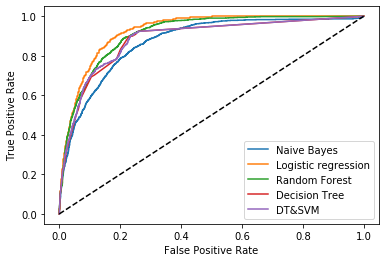

AUC for Gaussian Naive Bayes: 0.871563
AUC for Logistic Regression: 0.926419
AUC for Random Forest: 0.911552
AUC for Decision Tree: 0.883593
AUC for DT&SVM: 0.885294


In [56]:
print("------------------------------- ROC Curve --------------------------------------------------------------")
fpr, tpr, thresholds = roc_curve(y_test_nb, gnb.predict_proba(x_test_nb)[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_test_general, logreg.predict_proba(x_test_general)[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y_test_general, RF.predict_proba(x_test_general)[:, 1])
fpr4, tpr4, thresholds4 = roc_curve(y_test_general, DT.predict_proba(x_test_general)[:, 1])
fpr5, tpr5, thresholds5 = roc_curve(y_test_for_both, np.concatenate((y_pred_SVM_proba[:, 1], DT.predict_proba(x_test_for_DT)[:, 1])))
plt.plot(fpr, tpr, label = "ROC curve")
plt.plot(fpr2, tpr2, label = "ROC curve")
plt.plot(fpr3, tpr3, label = "ROC curve")
plt.plot(fpr4, tpr4, label = "ROC curve")
plt.plot(fpr5, tpr5, label = "ROC curve")
plt.legend(["Naive Bayes", "Logistic regression", "Random Forest", "Decision Tree", "DT&SVM"])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
print("AUC for Gaussian Naive Bayes: %f" % (roc_auc_score(y_test_nb, gnb.predict_proba(x_test_nb)[:, 1])))
print("AUC for Logistic Regression: %f" % (roc_auc_score(y_test_general, logreg.predict_proba(x_test_general)[:, 1])))
print("AUC for Random Forest: %f" % (roc_auc_score(y_test_general, RF.predict_proba(x_test_general)[:, 1])))
print("AUC for Decision Tree: %f" % (roc_auc_score(y_test_general, DT.predict_proba(x_test_general)[:, 1])))
print("AUC for DT&SVM: %f" % (roc_auc_score(y_test_for_both, np.concatenate((y_pred_SVM_proba[:, 1], DT.predict_proba(x_test_for_DT)[:, 1])))))

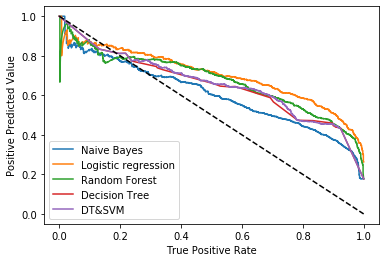

In [57]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

ppv1, tpr1, thresholds1 = precision_recall_curve(y_test_nb, gnb.predict_proba(x_test_nb)[:, 1])
ppv2, tpr2, thresholds2 = precision_recall_curve(y_test_general, logreg.predict_proba(x_test_general)[:, 1])
ppv3, tpr3, thresholds3 = precision_recall_curve(y_test_general, RF.predict_proba(x_test_general)[:, 1])
ppv4, tpr4, thresholds4 = precision_recall_curve(y_test_general, DT.predict_proba(x_test_general)[:, 1])
ppv5, tpr5, thresholds5 = precision_recall_curve(y_test_for_both, np.concatenate((y_pred_SVM_proba[:, 1], DT.predict_proba(x_test_for_DT)[:, 1])))
plt.plot(tpr1, ppv1)
plt.plot(tpr2, ppv2)
plt.plot(tpr3, ppv3)
plt.plot(tpr4, ppv4)
plt.plot(tpr5, ppv5)
plt.legend(["Naive Bayes", "Logistic regression", "Random Forest", "Decision Tree", "DT&SVM"])
plt.plot([0, 1], [1, 0], 'k--')
plt.xlabel("True Positive Rate")
plt.ylabel("Positive Predicted Value")
plt.show()